# Análisis de Mapas de Peso y Bordes para Segmentación de Núcleos

Este notebook implementa y analiza:
1. Detección de bordes usando operaciones morfológicas
2. Generación de mapas de peso para enfatizar bordes y compensar desbalance de clases
3. Visualización de resultados en muestras del dataset

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, morphology, segmentation
import cv2
from tqdm.notebook import tqdm

# Añadir directorio raíz al path para importar módulos propios
sys.path.append('..')
from src.weight_maps import (
    detect_edges,
    detect_inner_edges,
    generate_weight_map,
    visualize_weight_map
)

## 1. Carga de Datos

Primero, vamos a cargar algunas imágenes y máscaras para analizar.

In [2]:
# Directorio raíz del dataset
data_dir = '../data'

# Función para cargar imagen y máscara por ID
def load_sample(sample_id):
    """Carga una imagen y su máscara correspondiente."""
    # Construir rutas
    id_str = str(sample_id).zfill(5)
    img_path = os.path.join(data_dir, id_str, 'image.png')
    mask_path = os.path.join(data_dir, id_str, 'mask.png')
    
    # Verificar si las rutas existen
    if not os.path.exists(img_path) or not os.path.exists(mask_path):
        print(f"La imagen o máscara para ID {sample_id} no existe")
        return None, None
    
    # Cargar imagen y máscara
    image = io.imread(img_path)
    mask = io.imread(mask_path)
    
    return image, mask

# Cargar algunas muestras para análisis
# Elegimos algunos IDs de imágenes con núcleos que se tocan (basado en análisis exploratorio)
sample_ids = [1, 2, 3, 4]  # Podemos ajustar estos IDs según imágenes interesantes

samples = []
for sample_id in sample_ids:
    img, mask = load_sample(sample_id)
    if img is not None and mask is not None:
        samples.append((sample_id, img, mask))

print(f"Se cargaron {len(samples)} muestras")

Se cargaron 4 muestras


## 2. Análisis del Desbalance de Clases

Verificamos el desbalance entre píxeles de fondo y núcleo en nuestras muestras.

In [3]:
# Calcular estadísticas de desbalance para cada muestra
for sample_id, img, mask in samples:
    # Normalizar máscara
    mask_binary = mask.copy()
    if mask_binary.max() > 1:
        mask_binary = mask_binary / 255
    
    # Calcular porcentajes
    foreground_ratio = np.mean(mask_binary)
    foreground_percent = foreground_ratio * 100
    background_percent = (1 - foreground_ratio) * 100
    
    print(f"Muestra {sample_id}:")
    print(f"  - Píxeles de núcleo: {foreground_percent:.2f}%")
    print(f"  - Píxeles de fondo:  {background_percent:.2f}%")
    print(f"  - Ratio núcleo/fondo: 1:{background_percent/foreground_percent:.2f}")

Muestra 1:
  - Píxeles de núcleo: 8.72%
  - Píxeles de fondo:  91.28%
  - Ratio núcleo/fondo: 1:10.47
Muestra 2:
  - Píxeles de núcleo: 7.23%
  - Píxeles de fondo:  92.77%
  - Ratio núcleo/fondo: 1:12.83
Muestra 3:
  - Píxeles de núcleo: 28.45%
  - Píxeles de fondo:  71.55%
  - Ratio núcleo/fondo: 1:2.51
Muestra 4:
  - Píxeles de núcleo: 10.38%
  - Píxeles de fondo:  89.62%
  - Ratio núcleo/fondo: 1:8.64


## 3. Detección de Bordes

Detectamos y visualizamos bordes en las máscaras, prestando especial atención a los bordes entre núcleos.

Muestra 1:
  - Total píxeles de borde: 1080.0
  - Píxeles de borde interno: 1080.0 (100.00% del total)


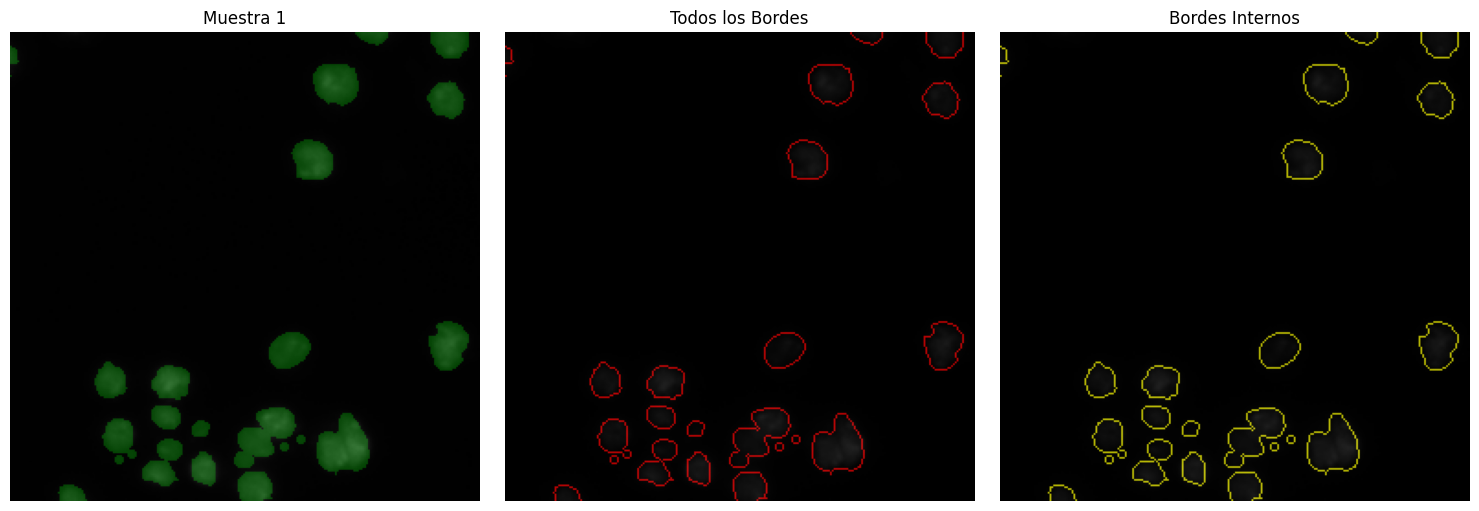

Muestra 2:
  - Total píxeles de borde: 1241.0
  - Píxeles de borde interno: 1241.0 (100.00% del total)


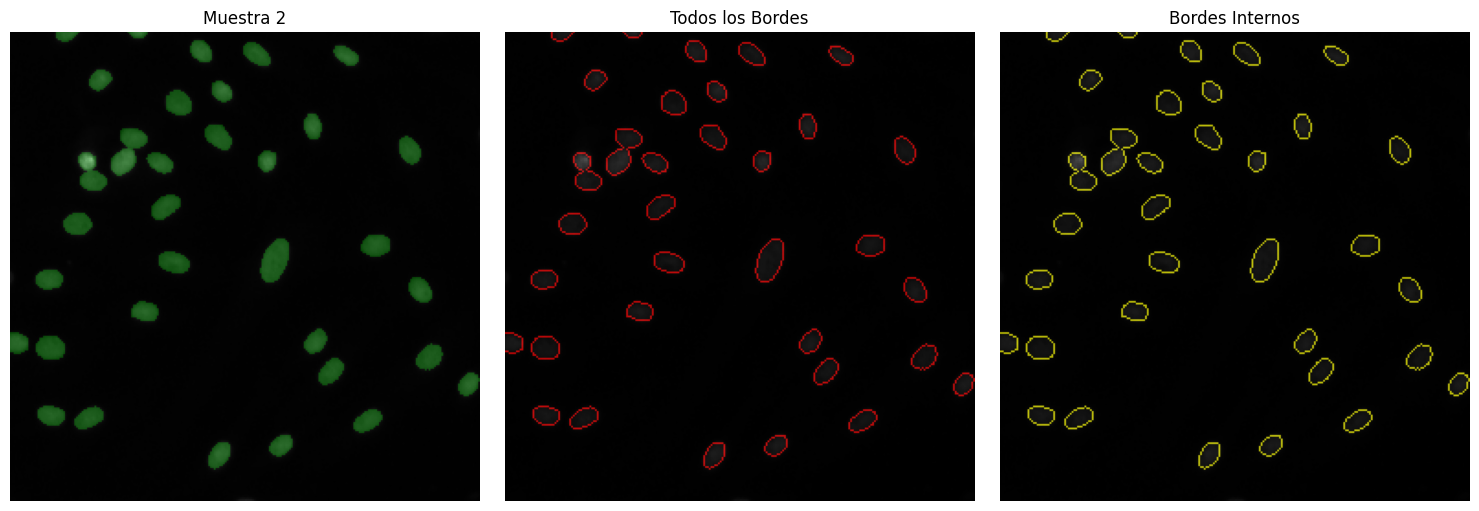

Muestra 3:
  - Total píxeles de borde: 1238.0
  - Píxeles de borde interno: 1238.0 (100.00% del total)


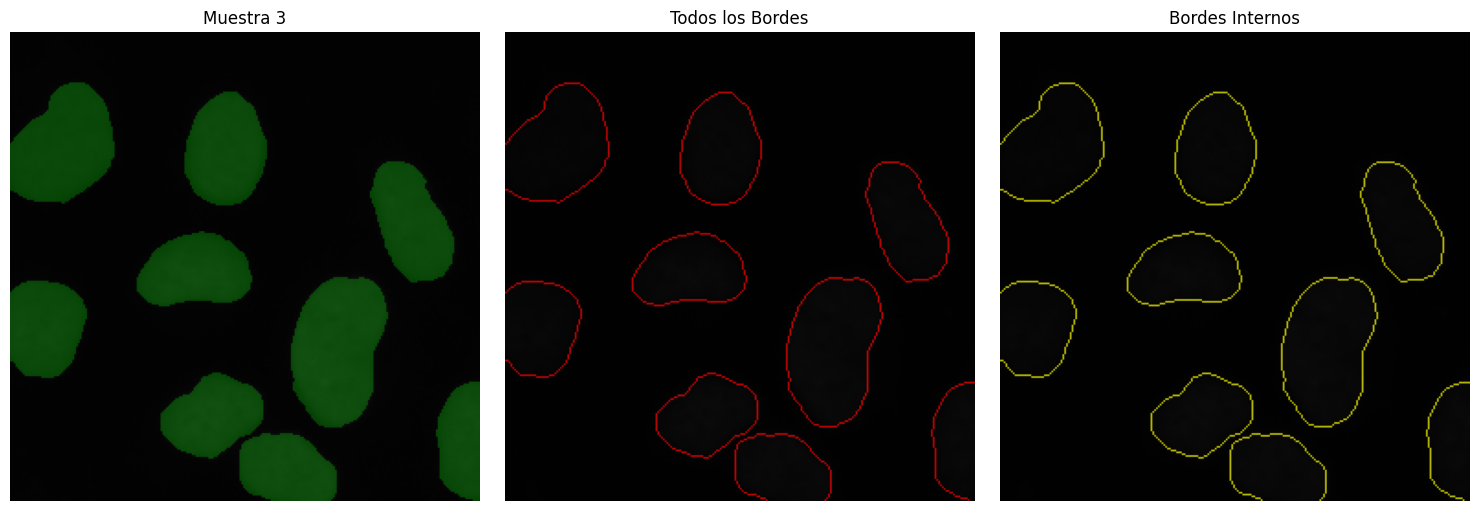

Muestra 4:
  - Total píxeles de borde: 477.0
  - Píxeles de borde interno: 477.0 (100.00% del total)


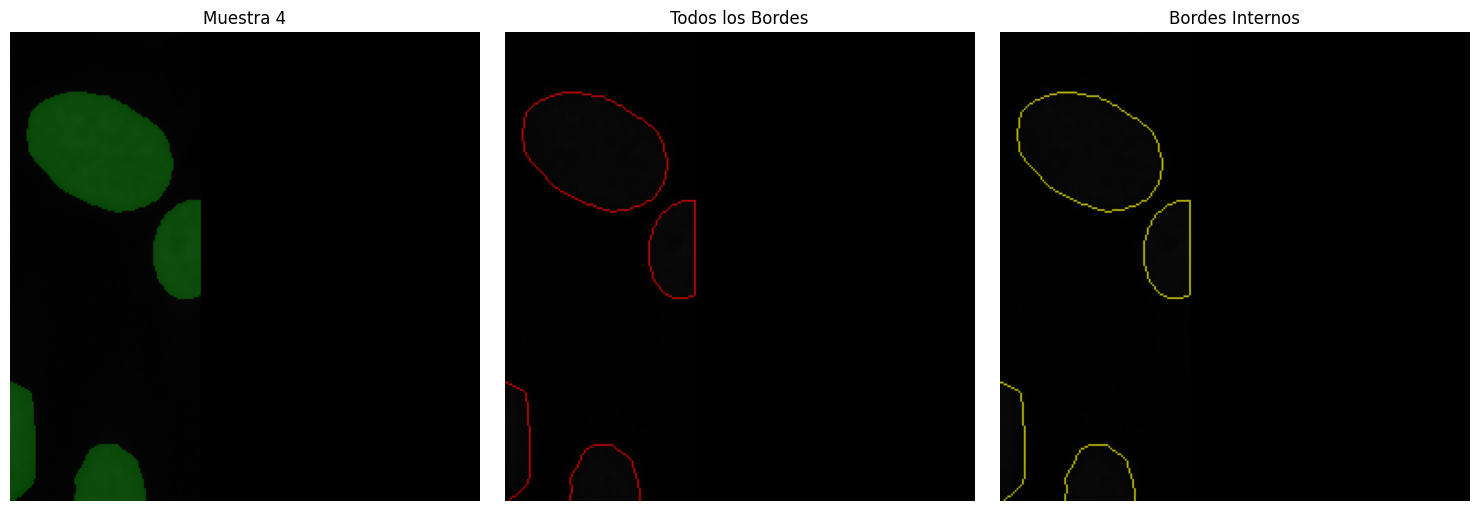

In [4]:
# Analizar y visualizar bordes para cada muestra
for sample_id, img, mask in samples:
    # Normalizar máscara
    mask_binary = mask.copy()
    if mask_binary.max() > 1:
        mask_binary = mask_binary / 255
    
    # Detectar todos los bordes y bordes internos
    edges = detect_edges(mask_binary)
    inner_edges = detect_inner_edges(mask_binary)
    
    # Calcular estadísticas de bordes
    total_edge_pixels = edges.sum()
    inner_edge_pixels = inner_edges.sum()
    inner_edge_ratio = inner_edge_pixels / total_edge_pixels if total_edge_pixels > 0 else 0
    
    print(f"Muestra {sample_id}:")
    print(f"  - Total píxeles de borde: {total_edge_pixels}")
    print(f"  - Píxeles de borde interno: {inner_edge_pixels} ({inner_edge_ratio*100:.2f}% del total)")
    
    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Imagen original con máscara superpuesta
    axes[0].imshow(img)
    mask_overlay = np.zeros_like(img, dtype=np.float32)
    if len(mask_overlay.shape) == 3:  # RGB
        mask_overlay[:, :, 1] = mask_binary * 0.5  # Verde semitransparente
    axes[0].imshow(mask_overlay, alpha=0.5)
    axes[0].set_title(f'Muestra {sample_id}')
    axes[0].axis('off')
    
    # Todos los bordes
    axes[1].imshow(img if len(img.shape) == 3 else np.stack([img]*3, axis=2))
    edges_overlay = np.zeros_like(img, dtype=np.float32)
    if len(edges_overlay.shape) == 3:  # RGB
        edges_overlay[:, :, 0] = edges  # Rojo para bordes
    axes[1].imshow(edges_overlay, alpha=0.7)
    axes[1].set_title('Todos los Bordes')
    axes[1].axis('off')
    
    # Bordes internos
    axes[2].imshow(img if len(img.shape) == 3 else np.stack([img]*3, axis=2))
    inner_overlay = np.zeros_like(img, dtype=np.float32)
    if len(inner_overlay.shape) == 3:  # RGB
        inner_overlay[:, :, 0] = inner_edges  # Rojo para bordes internos
        inner_overlay[:, :, 1] = inner_edges  # Verde para bordes internos = amarillo
    axes[2].imshow(inner_overlay, alpha=0.7)
    axes[2].set_title('Bordes Internos')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

## 4. Generación de Mapas de Peso

Creamos mapas de peso para cada muestra y visualizamos cómo enfatizan los bordes y compensan el desbalance.

Muestra 1:
  - Valor mínimo del mapa: 0.0000
  - Valor máximo del mapa: 12.0015
  - Valor medio del mapa: 1.0000


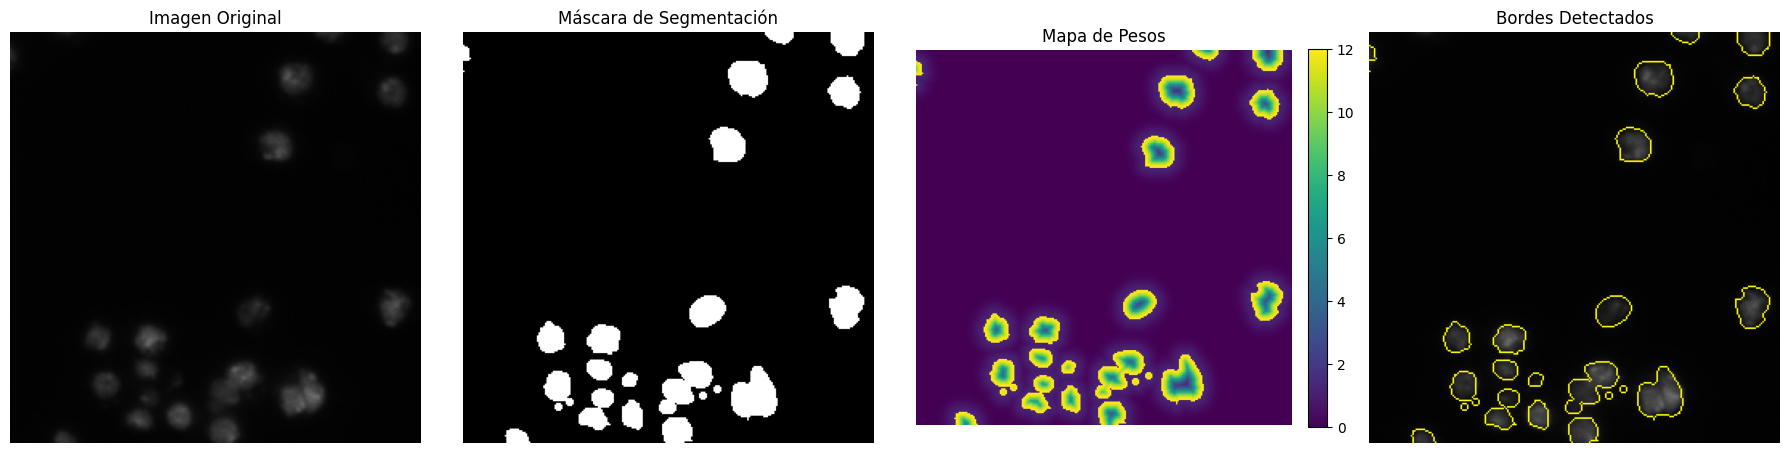

Muestra 2:
  - Valor mínimo del mapa: 0.0000
  - Valor máximo del mapa: 12.3705
  - Valor medio del mapa: 1.0000


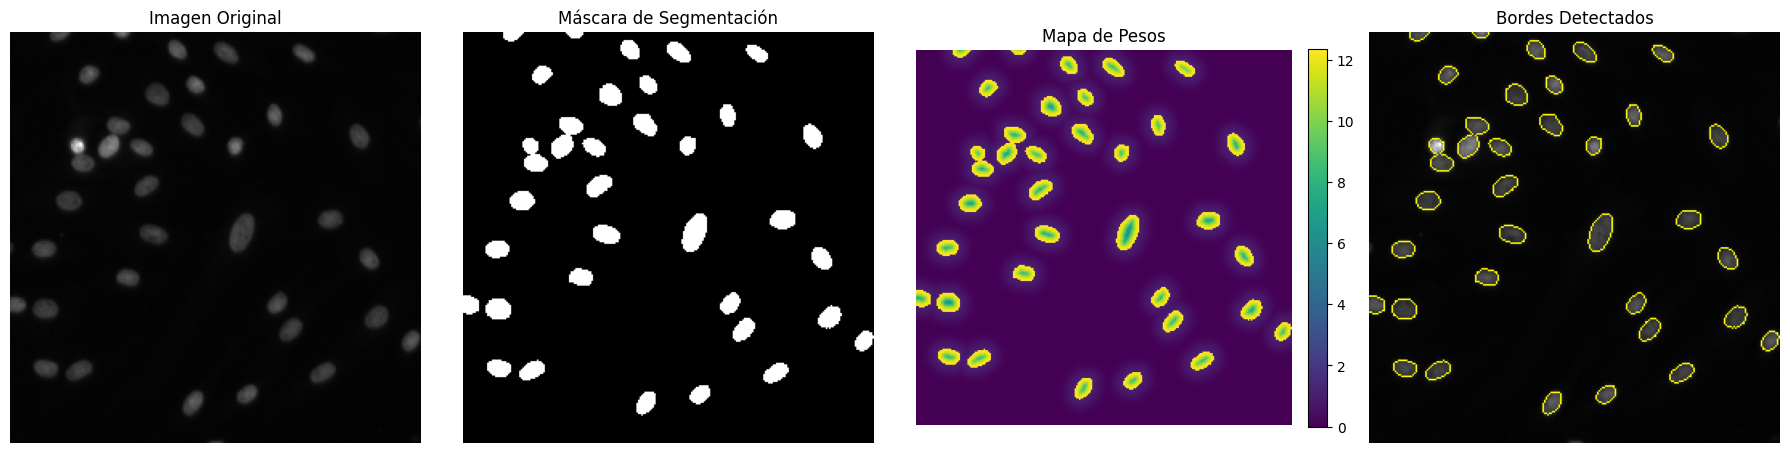

Muestra 3:
  - Valor mínimo del mapa: 0.0000
  - Valor máximo del mapa: 5.5635
  - Valor medio del mapa: 1.0000


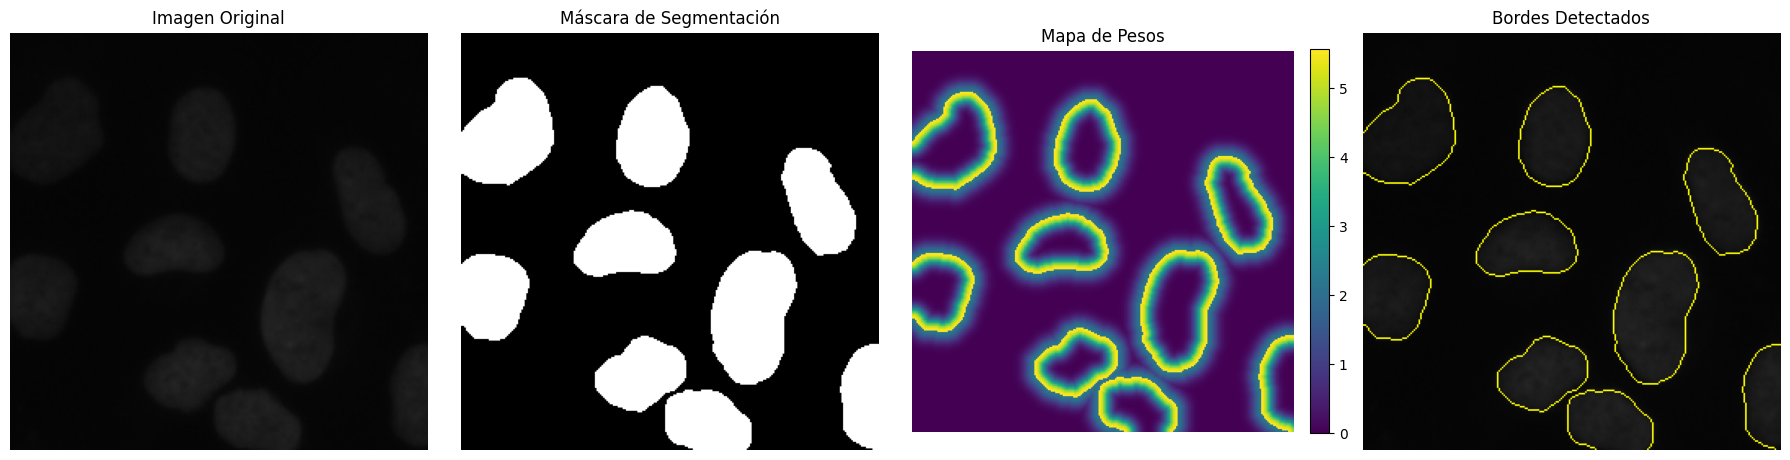

Muestra 4:
  - Valor mínimo del mapa: 0.0000
  - Valor máximo del mapa: 18.9923
  - Valor medio del mapa: 1.0000


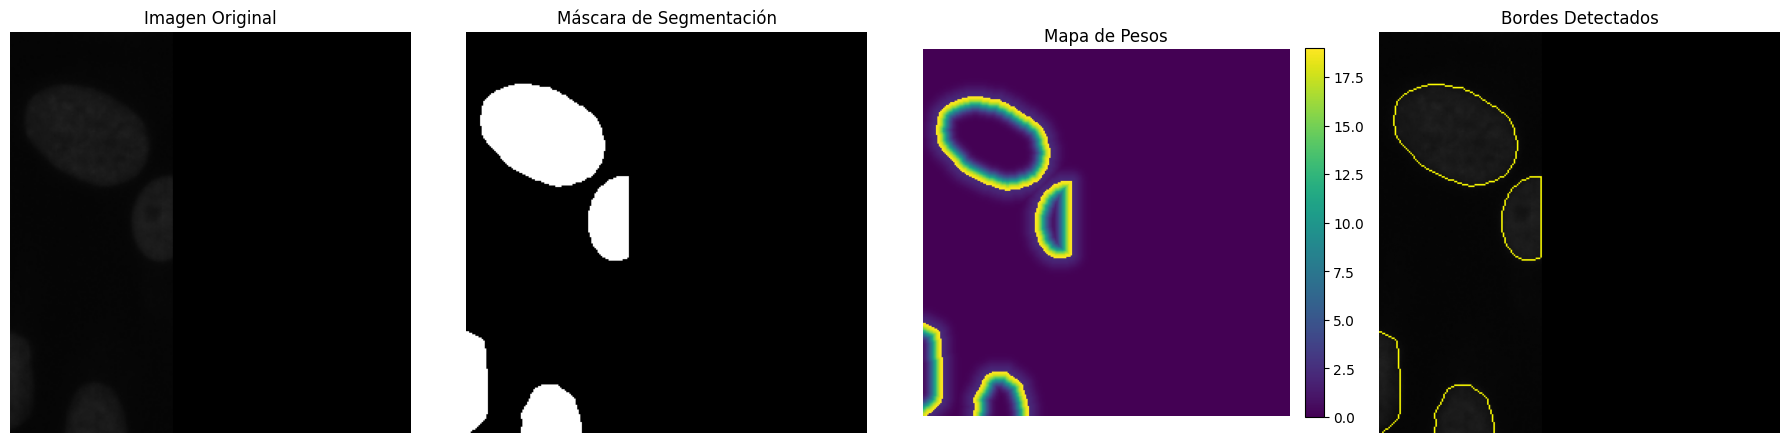

In [5]:
# Generar y visualizar mapas de peso para cada muestra
for sample_id, img, mask in samples:
    # Generar mapa de peso
    weight_map = generate_weight_map(mask, w0=10, sigma=5)
    
    # Estadísticas del mapa de peso
    print(f"Muestra {sample_id}:")
    print(f"  - Valor mínimo del mapa: {weight_map.min():.4f}")
    print(f"  - Valor máximo del mapa: {weight_map.max():.4f}")
    print(f"  - Valor medio del mapa: {weight_map.mean():.4f}")
    
    # Visualizar usando nuestra función
    _ = visualize_weight_map(img, mask, weight_map, show_edges=True)

## 5. Análisis de Efectividad del Mapa de Pesos

Analizamos cómo los mapas de peso enfatizan las regiones críticas (bordes internos) y compensan el desbalance.

Muestra 1:
  - Peso medio en núcleos: 9.8719
  - Peso medio en fondo: 0.1524
  - Peso medio en bordes internos: 12.0015
  - Relación peso bordes/fondo: 78.74x
  - Relación peso núcleos/fondo: 64.77x


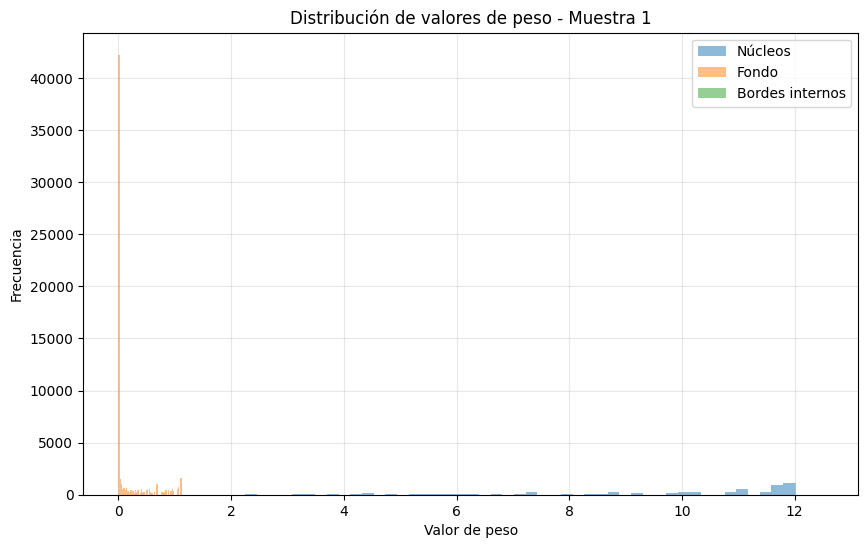

Muestra 2:
  - Peso medio en núcleos: 11.3881
  - Peso medio en fondo: 0.1906
  - Peso medio en bordes internos: 12.3705
  - Relación peso bordes/fondo: 64.89x
  - Relación peso núcleos/fondo: 59.74x


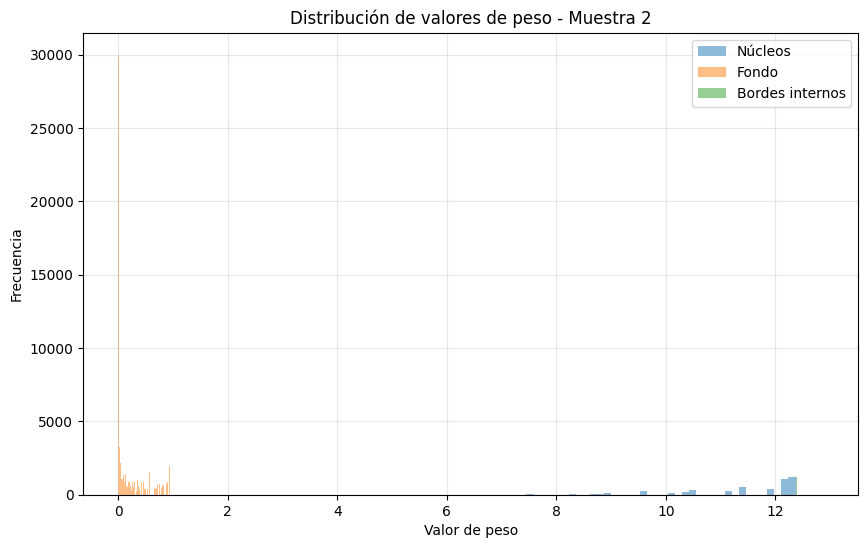

Muestra 3:
  - Peso medio en núcleos: 2.4750
  - Peso medio en fondo: 0.4135
  - Peso medio en bordes internos: 5.5635
  - Relación peso bordes/fondo: 13.45x
  - Relación peso núcleos/fondo: 5.99x


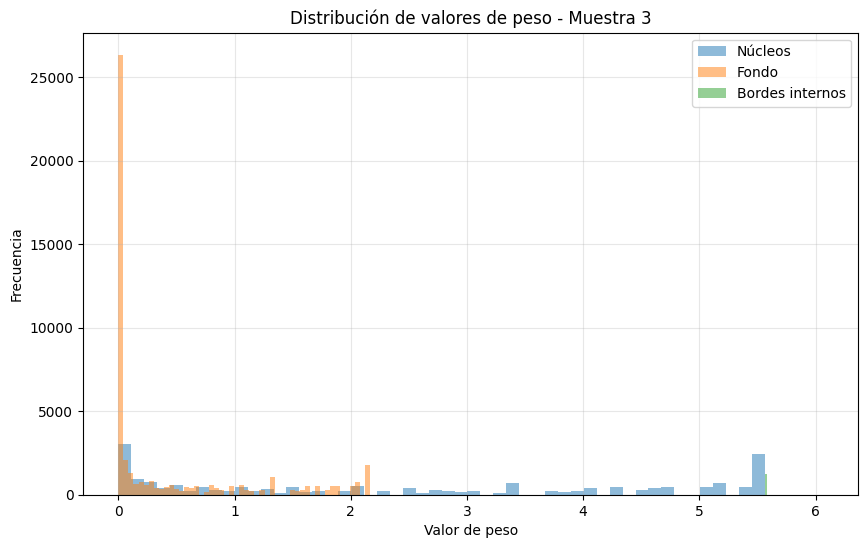

Muestra 4:
  - Peso medio en núcleos: 8.5405
  - Peso medio en fondo: 0.1269
  - Peso medio en bordes internos: 18.9923
  - Relación peso bordes/fondo: 149.69x
  - Relación peso núcleos/fondo: 67.31x


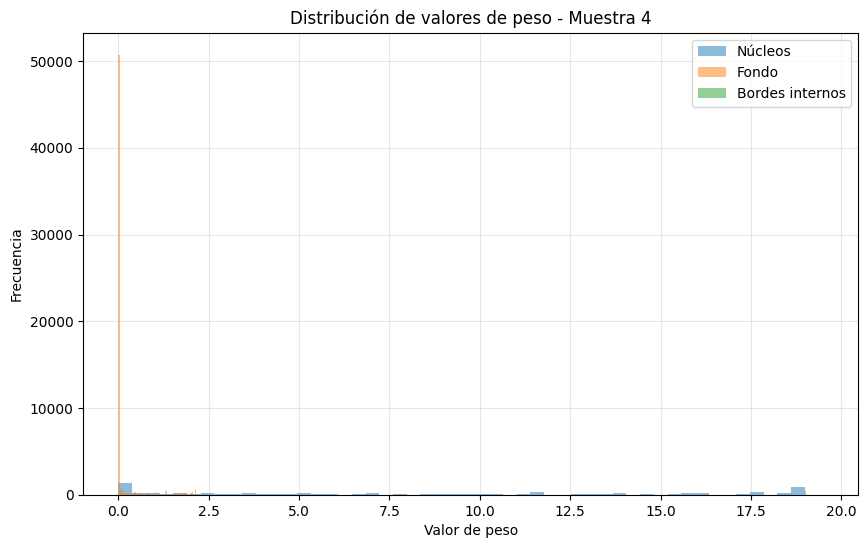

In [6]:
# Analizar la eficacia del mapa de peso para cada muestra
for sample_id, img, mask in samples:
    # Normalizar máscara
    mask_binary = mask.copy()
    if mask_binary.max() > 1:
        mask_binary = mask_binary / 255
    
    # Detectar bordes internos
    inner_edges = detect_inner_edges(mask_binary)
    
    # Generar mapa de peso
    weight_map = generate_weight_map(mask, w0=10, sigma=5)
    
    # Calcular peso medio en diferentes regiones
    foreground_mean = weight_map[mask_binary > 0].mean() if (mask_binary > 0).sum() > 0 else 0
    background_mean = weight_map[mask_binary == 0].mean() if (mask_binary == 0).sum() > 0 else 0
    edge_mean = weight_map[inner_edges > 0].mean() if (inner_edges > 0).sum() > 0 else 0
    
    print(f"Muestra {sample_id}:")
    print(f"  - Peso medio en núcleos: {foreground_mean:.4f}")
    print(f"  - Peso medio en fondo: {background_mean:.4f}")
    print(f"  - Peso medio en bordes internos: {edge_mean:.4f}")
    print(f"  - Relación peso bordes/fondo: {edge_mean/background_mean:.2f}x")
    print(f"  - Relación peso núcleos/fondo: {foreground_mean/background_mean:.2f}x")
    
    # Visualización de histograma de valores de peso
    plt.figure(figsize=(10, 6))
    
    # Histograma para cada región
    if (mask_binary > 0).sum() > 0:
        plt.hist(weight_map[mask_binary > 0].flatten(), bins=50, alpha=0.5, label='Núcleos')
    if (mask_binary == 0).sum() > 0:
        plt.hist(weight_map[mask_binary == 0].flatten(), bins=50, alpha=0.5, label='Fondo')
    if (inner_edges > 0).sum() > 0:
        plt.hist(weight_map[inner_edges > 0].flatten(), bins=50, alpha=0.5, label='Bordes internos')
        
    plt.title(f'Distribución de valores de peso - Muestra {sample_id}')
    plt.xlabel('Valor de peso')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

## 6. Ajuste de Parámetros para Mapas de Peso

Experimentamos con diferentes valores de parámetros para optimizar los mapas de peso.

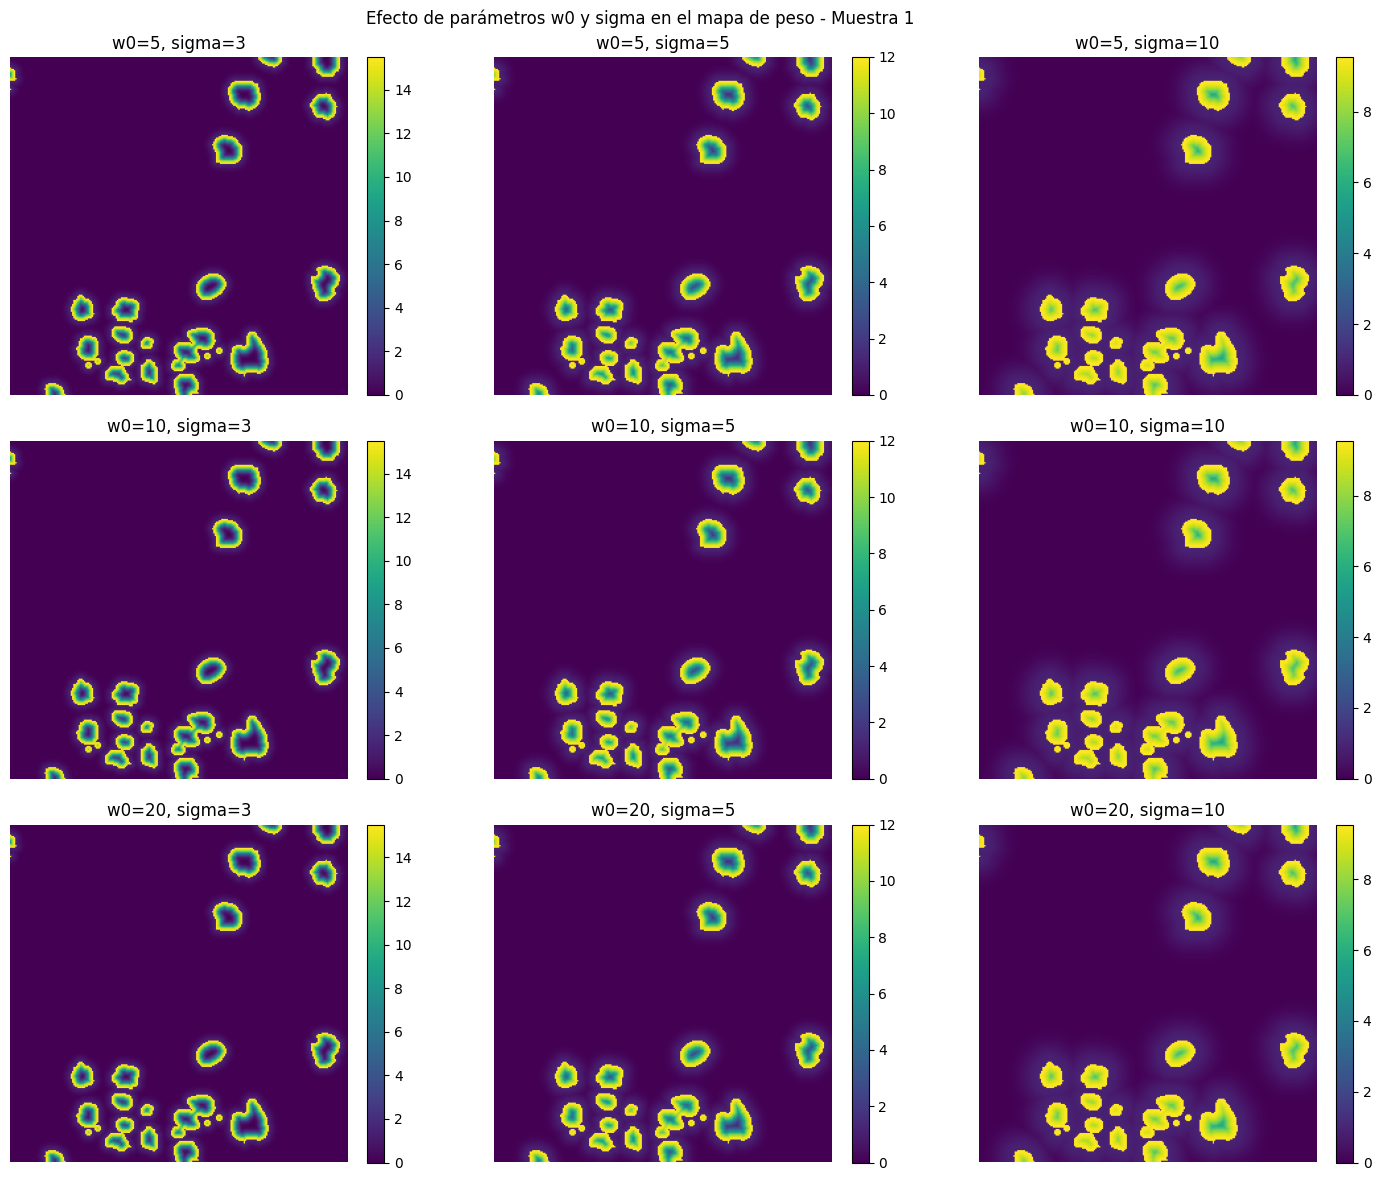

In [7]:
# Probar diferentes parámetros w0 y sigma
# Tomamos una muestra para experimentar
if len(samples) > 0:
    sample_id, img, mask = samples[0]  # Usamos la primera muestra
    
    # Valores de parámetros a probar
    w0_values = [5, 10, 20]
    sigma_values = [3, 5, 10]
    
    # Crear grid de visualización
    fig, axes = plt.subplots(len(w0_values), len(sigma_values), figsize=(15, 12))
    
    for i, w0 in enumerate(w0_values):
        for j, sigma in enumerate(sigma_values):
            # Generar mapa de peso con estos parámetros
            weight_map = generate_weight_map(mask, w0=w0, sigma=sigma)
            
            # Visualizar
            im = axes[i, j].imshow(weight_map, cmap='viridis')
            axes[i, j].set_title(f'w0={w0}, sigma={sigma}')
            axes[i, j].axis('off')
            plt.colorbar(im, ax=axes[i, j], fraction=0.046, pad=0.04)
    
    plt.suptitle(f'Efecto de parámetros w0 y sigma en el mapa de peso - Muestra {sample_id}')
    plt.tight_layout()
    plt.show()

## 7. Conclusiones

Los mapas de peso generados cumplen dos funciones principales:

1. **Enfatizar bordes**: Asignando mayor peso a los píxeles cercanos a los bordes, especialmente los bordes internos entre núcleos adyacentes, guiamos al modelo a prestar especial atención a estas regiones críticas durante el entrenamiento.

2. **Compensar desbalance de clases**: Asignando un factor de peso mayor a los píxeles de núcleo (clase minoritaria) en relación a los píxeles de fondo, contrarrestamos el sesgo que podría tener el modelo hacia la clase mayoritaria.

Estos mapas de peso se integrarán en la función de pérdida durante el entrenamiento para mejorar la precisión de la segmentación, especialmente en los límites entre núcleos adyacentes.